In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
from glob import glob

plt.ion()

## Data Augmentation and Normalization

In [2]:
DATA_TRANSFORM = {'Train' : transforms.Compose([transforms.RandomRotation(5),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomResizedCrop(224, scale = (0.96, 1.0), ratio = (0.95, 1.05)),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                                                                                             
                  'Validate' : transforms.Compose([transforms.Resize([244, 244]),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

## File Directories

In [3]:
# Setup Directories
FILE_PATH = 'E:/Machine Learning/Datasets/Cat & Dog Dataset/'
IMAGES = glob(os.path.join(FILE_PATH, 'Data/*.jpg'))
CHECKPOINT_PATH = 'E:/Machine Learning/Datasets/Cat & Dog Dataset/Checkpoint/checkpoint.tar'

# Check Number of Images
NUM_IMAGE = len(IMAGES)

# Shuffle the Images
SHUFFLE = np.random.permutation(NUM_IMAGE)

FIRST_TIME = False # Set to True if you run this for the first time

if (FIRST_TIME):
    # Create Directories with Labels
    for FOLDER_OUT in ['Train', 'Validate']:
        for FOLDER_IN in ['Dog', 'Cat']:
            os.makedirs(os.path.join(FILE_PATH, FOLDER_OUT, FOLDER_IN))

    # Move Images to Validate Folders
    for INDEX in SHUFFLE[:2000]:
        LABEL = IMAGES[INDEX].split('\\')[-1].split('.')[0]
        IMAGE = IMAGES[INDEX].split('\\')[-1]
        shutil.move(IMAGES[INDEX], os.path.join(FILE_PATH, 'Validate', LABEL))

    # Move Images to Train Folder
    NEW_IMAGES = glob(os.path.join(FILE_PATH, 'Data/*.jpg'))

    for IMAGE in NEW_IMAGES:
        LABEL = IMAGE.split('\\')[-1].split('.')[0]
        shutil.move(IMAGE, os.path.join(FILE_PATH, 'Train', LABEL))

## Input Pipeline

In [4]:
IMAGE_DATASET = {X : datasets.ImageFolder(os.path.join(FILE_PATH, X), DATA_TRANSFORM[X]) 
                 for X in ['Train', 'Validate']}

DATALOADER = {X : torch.utils.data.DataLoader(IMAGE_DATASET[X], batch_size = 3, shuffle = True, num_workers = 4) 
              for X in ['Train', 'Validate']}

DATASET_SIZE = {X : len(IMAGE_DATASET[X]) 
                for X in ['Train', 'Validate']}

NUM_EPOCH = 10

In [5]:
# Use GPU for Processing
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CLASS_NAME = IMAGE_DATASET['Train'].classes

print(CLASS_NAME)
print('Train Image Size =', DATASET_SIZE['Train'])
print('Validate Image Size =', DATASET_SIZE['Validate'])

['Cat', 'Dog']
Train Image Size = 23000
Validate Image Size = 2000


In [6]:
def Train_Model(MODEL, CRITERION, OPTIMIZER, SCHEDULER, NUM_EPOCH = 5, CHECKPOINT = None):
    SINCE = time.time()
    
    if CHECKPOINT == None:
        BEST_MODEL = copy.deepcopy(MODEL.state_dict())
        BEST_LOSS = math.inf
        BEST_ACCURACY = 0.0
    else:
        print('Validation Loss :', CHECKPOINT['BEST_VAL_LOSS'], '--- Validation Accuracy :', CHECKPOINT['BEST_VAL_ACC'])
        MODEL.load_state_dict(CHECKPOINT['MODEL_STATE_DICT'])
        BEST_MODEL = copy.deepcopy(MODEL.state_dict())
        OPTIMIZER.load_state_dict(CHECKPOINT['OPTIMIZER_STATE_DICT'])
        SCHEDULER.load_state_dict(CHECKPOINT['SCHEDULER_STATE_DICT'])
        BEST_LOSS = CHECKPOINT["BEST_VAL_LOSS"]
        BEST_ACCURACY = CHECKPOINT['BEST_VAL_ACC']
        
    for EPOCH in range(NUM_EPOCH):
        print('EPOCH', EPOCH + 1)
        print('-' * 25)
        
        for PHASE in ['Train', 'Validate']:
            if PHASE == 'Train':
                SCHEDULER.step()
                MODEL.train()
            else:
                MODEL.eval()
                
            RUNNING_LOSS = 0.0
            RUNNING_CORRECT = 0
            
            for (INPUTS, LABELS) in DATALOADER[PHASE]:
                INPUTS = INPUTS.to(DEVICE)
                LABELS = LABELS.to(DEVICE)
                
                OPTIMIZER.zero_grad()
                
                with torch.set_grad_enabled(PHASE == 'Train'):
                    OUTPUTS = MODEL(INPUTS)
                    _, PREDICTION = torch.max(OUTPUTS, 1)
                    LOSS = CRITERION(OUTPUTS, LABELS)
                    
                    if PHASE == 'Train':
                        LOSS.backward()
                        OPTIMIZER.step()
                        
            RUNNING_LOSS += LOSS.item() * INPUTS.size(0)
            RUNNING_CORRECT += torch.sum(PREDICTION == LABELS.data)
            
        EPOCH_LOSS = RUNNING_LOSS / DATASET_SIZE[PHASE]
        EPOCH_ACC = RUNNING_CORRECT.double() 
        
        print('Loss = {:.4f} --- Accuracy = {:.4f}'.format(EPOCH_LOSS, EPOCH_ACC))
        
        if PHASE == 'Validate' and EPOCH_LOSS < BEST_LOSS:
            print('New Model Found with Loss of {:.4f}, Beating Record of {:.4f}'.format(EPOCH_LOSS, BEST_LOSS))
            BEST_LOSS = EPOCH_LOSS
            BEST_ACCURACY = EPOCH_ACC
            BEST_MODEL = copy.deepcopy(MODEL.state_dict())
            
        print()
        
    TIME_ELAPSE = time.time() - SINCE
    print('Time Taken :', TIME_ELAPSE)
    print('Best Loss = {:.4f} --- Best Accuracy = {:.4f}'.format(BEST_LOSS, BEST_ACCURACY))
    
    MODEL.load_state_dict(BEST_MODEL)
    
    return MODEL, BEST_LOSS, BEST_ACCURACY

In [7]:
MODEL = torchvision.models.resnet50(pretrained = True)

In [8]:
for PARAMETERS in MODEL.parameters():
    PARAMETERS.requires_grad = False
    
NUM_FEATURES = MODEL.fc.in_features
MODEL.fc = nn.Linear(NUM_FEATURES, 2)

MODEL = MODEL.to(DEVICE)
CRITERION = nn.CrossEntropyLoss()

OPTIMIZER = optim.SGD(MODEL.fc.parameters(), lr = 0.001, momentum = 0.9)
SCHEDULER = lr_scheduler.StepLR(OPTIMIZER, step_size = 7, gamma = 0.1)

In [9]:
try:
    CHECKPOINT = torch.load(CHECKPOINT_PATH)
    print('Checkpoint Loaded')
except:
    CHECKPOINT = None
    print('Checkpoint Not Found')

Checkpoint Loaded


In [10]:
MODEL, BEST_VAL_LOSS, BEST_VAL_ACC = Train_Model(MODEL, CRITERION, OPTIMIZER, SCHEDULER, NUM_EPOCH, CHECKPOINT)

Validation Loss : 9.088516235351562e-07 --- Validation Accuracy : tensor(2., device='cuda:0', dtype=torch.float64)
EPOCH 1
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 2
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 3
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 4
-------------------------
Loss = 0.0006 --- Accuracy = 1.0000

EPOCH 5
-------------------------
Loss = 0.0001 --- Accuracy = 2.0000

EPOCH 6
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 7
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 8
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000
New Model Found with Loss of 0.0000, Beating Record of 0.0000

EPOCH 9
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

EPOCH 10
-------------------------
Loss = 0.0000 --- Accuracy = 2.0000

Time Taken : 1705.2975187301636
Best Loss = 0.0000 --- Best Accuracy = 2.0000


In [11]:
torch.save({'MODEL_STATE_DICT' : MODEL.state_dict(),
            'OPTIMIZER_STATE_DICT' : OPTIMIZER.state_dict(),
            'BEST_VAL_LOSS' : BEST_VAL_LOSS,
            'BEST_VAL_ACC' : BEST_VAL_ACC,
            'SCHEDULER_STATE_DICT' : SCHEDULER.state_dict()}, CHECKPOINT_PATH)

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
def Visualize_Model(MODEL, NUM_IMAGE = 6):
    WAS_TRAINING = MODEL.training
    MODEL.eval()
    IMAGE_SO_FAR = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (INPUTS, LABELS) in enumerate(DATALOADER['Validate']):
            INPUTS = INPUTS.to(DEVICE)
            LABELS = LABELS.to(DEVICE)
            
            OUTPUT = MODEL(INPUTS)
            _, PREDICTION = torch.max(OUTPUT, 1)
            
            for j in range(INPUTS.size()[0]):
                IMAGE_SO_FAR += 1
                ax = plt.subplot(3, 2, IMAGE_SO_FAR)
                ax.axis('off')
                ax.set_title('Predicted : {}'.format(CLASS_NAME[PREDICTION[j]]))
                imshow(INPUTS.cpu().data[j])
                
                if IMAGE_SO_FAR == NUM_IMAGE:
                    MODEL.train(mode = WAS_TRAINING)
                    return
                    
        MODEL.train(mode = WAS_TRAINING)

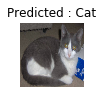

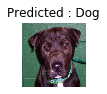

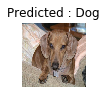

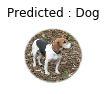

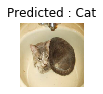

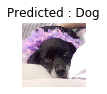

In [14]:
Visualize_Model(MODEL)

plt.ioff()
plt.show()